# Documentation

This note is aim to demo how insurance company model and evaluate claim severity.

The data used here are from [Actuarial loss prediction](https://www.kaggle.com/competitions/actuarial-loss-estimation/overview).

# Download file and environment

In [1]:
# !pip install kaggle
# !kaggle competitions download -c actuarial-loss-estimation
# 
# ! pip install pandas numpy matplotlib ydata-profiling scikit-learn xgboost

In [2]:
# # importing the zipfile module 
# from zipfile import ZipFile 
# # loading the temp.zip and creating a zip object 
# with ZipFile("actuarial-loss-estimation.zip", 'r') as zObject: 
# 	zObject.extractall(path="./data") 


# EDA

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [4]:
train_dev = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/train.csv")
# rename misspelled columns names
train_dev.rename(columns={'InitialIncurredCalimsCost': 'InitialIncurredClaimsCost'}, inplace=True)
test.rename(columns={'InitialIncurredCalimsCost': 'InitialIncurredClaimsCost'}, inplace=True)

print(train_dev.columns)

Index(['ClaimNumber', 'DateTimeOfAccident', 'DateReported', 'Age', 'Gender',
       'MaritalStatus', 'DependentChildren', 'DependentsOther', 'WeeklyWages',
       'PartTimeFullTime', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek',
       'ClaimDescription', 'InitialIncurredClaimsCost',
       'UltimateIncurredClaimCost'],
      dtype='object')


In [5]:
from ydata_profiling import ProfileReport

profile = ProfileReport(train_dev, title="Profiling Loss Cost Report")
profile.to_file("./eda_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

count    54000.000000
mean       416.364807
std        248.638669
min          1.000000
10%        200.000000
20%        200.000000
30%        244.710000
40%        333.478000
50%        392.200000
60%        447.724000
70%        500.000000
80%        548.014000
90%        681.451000
95%        817.005500
99%       1237.520000
100%      7497.000000
max       7497.000000
Name: WeeklyWages, dtype: float64
0    200.0
Name: WeeklyWages, dtype: float64


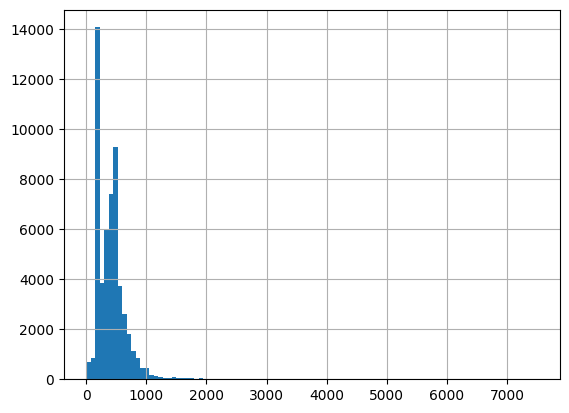

In [6]:
print(train_dev['WeeklyWages'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]))
train_dev['WeeklyWages'].hist(bins=100)
print(train_dev['WeeklyWages'].mode())

count    54000.000000
mean        37.735084
std         12.568704
min          0.000000
10%         34.500000
20%         38.000000
30%         38.000000
40%         38.000000
50%         38.000000
60%         38.000000
70%         38.000000
80%         40.000000
90%         40.000000
95%         40.000000
99%         60.000000
100%       640.000000
max        640.000000
Name: HoursWorkedPerWeek, dtype: float64
0    38.0
Name: HoursWorkedPerWeek, dtype: float64


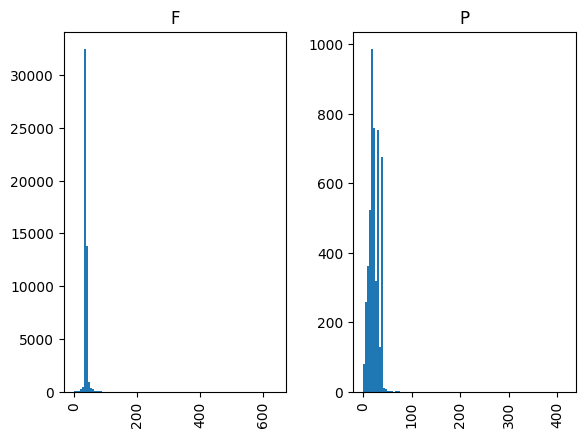

In [7]:
print(train_dev['HoursWorkedPerWeek'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]))
train_dev['HoursWorkedPerWeek'].hist(by=train_dev['PartTimeFullTime'], bins=100)
print(train_dev['HoursWorkedPerWeek'].mode())

In [8]:
# Variable consistency
# HoursWorkedPerWeek is zero but wage may not
print(train_dev[train_dev['HoursWorkedPerWeek'] == 0][['WeeklyWages','PartTimeFullTime', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek']].sample(10, random_state=42).reset_index(drop=True))
print(f"Precnet of HoursWorkedPerWeek is zero: {sum(train_dev['HoursWorkedPerWeek'] == 0) / len(train_dev['HoursWorkedPerWeek']): .3%}")

   WeeklyWages PartTimeFullTime  HoursWorkedPerWeek  DaysWorkedPerWeek
0       418.00                P                 0.0                  1
1       596.15                F                 0.0                  5
2       439.80                F                 0.0                  5
3         1.00                F                 0.0                  1
4        68.00                P                 0.0                  1
5       500.00                P                 0.0                  1
6       500.00                F                 0.0                  5
7       455.00                F                 0.0                  3
8       481.08                F                 0.0                  1
9       368.60                F                 0.0                  5
Precnet of HoursWorkedPerWeek is zero:  0.054%


count    5.400000e+04
mean     7.841146e+03
std      2.058408e+04
min      1.000000e+00
10%      5.000000e+02
20%      5.000000e+02
30%      9.500000e+02
40%      1.260000e+03
50%      2.000000e+03
60%      3.500000e+03
70%      7.500000e+03
80%      1.000000e+04
90%      1.850000e+04
95%      3.000000e+04
99%      7.500000e+04
100%     2.000000e+06
max      2.000000e+06
Name: InitialIncurredClaimsCost, dtype: float64


Text(0.5, 1.0, 'Log InitialIncurredClaimsCost')

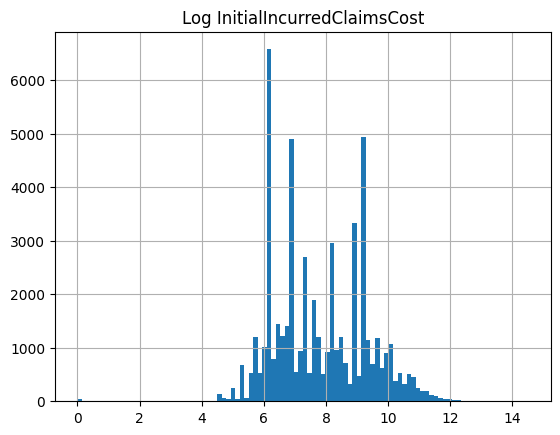

In [9]:
# Closer look in Target
print(train_dev['InitialIncurredClaimsCost'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]))
train_dev['InitialIncurredClaimsCost_log'] = np.log(train_dev['InitialIncurredClaimsCost'])
train_dev['InitialIncurredClaimsCost_log'].hist(bins=100)
plt.title('Log InitialIncurredClaimsCost')

count    5.400000e+04
mean     1.100337e+04
std      3.339099e+04
min      1.218868e+02
10%      4.238908e+02
20%      7.170157e+02
30%      1.209882e+03
40%      1.979777e+03
50%      3.371242e+03
60%      5.113480e+03
70%      6.915432e+03
80%      1.043851e+04
90%      2.400578e+04
95%      4.522418e+04
99%      1.390250e+05
100%     4.027136e+06
max      4.027136e+06
Name: UltimateIncurredClaimCost, dtype: float64


Text(0.5, 1.0, 'Log UltimateIncurredClaimCost')

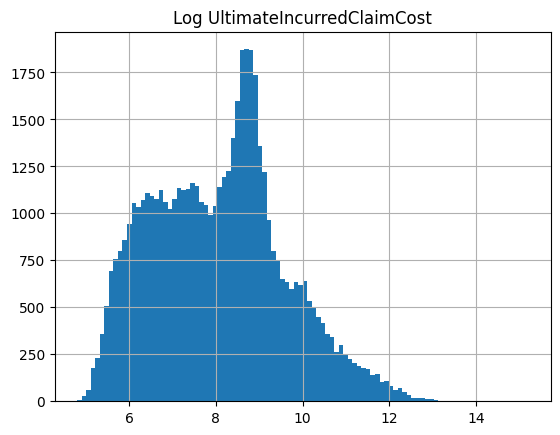

In [10]:
# Closer look in Target
print(train_dev['UltimateIncurredClaimCost'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]))
train_dev['UltimateIncurredClaimCost_log'] = np.log(train_dev['UltimateIncurredClaimCost'])
train_dev['UltimateIncurredClaimCost_log'].hist(bins=100)
plt.title('Log UltimateIncurredClaimCost')

Summary of the features
- Features with tail need to be capped: 
    - Continue: HoursWorkedPerWeek, WeeklyWages, 
    - Numerical: DependentsOther, DependentChildren
    - Categorical: Gender
- Highly correlated features: 
    - DaysWorkedPerWeek, PartTimeFullTime
    - HoursWorkedPerWeek, DaysWorkedPerWeek
    - Age, MaritalStatus
    - PartTimeFullTime, Gender
- Date time: DateTimeOfAccident, DateReported
- NLP feature: ClaimDescription
- Targets: UltimateIncurredClaimCost
    - Feature highly correlated to targets: InitialIncurredClaimsCost, Age, DependentChildren, WeeklyWages

## Feature Engineer

In [11]:
columns_input = train_dev.columns.to_list()
columns_input

['ClaimNumber',
 'DateTimeOfAccident',
 'DateReported',
 'Age',
 'Gender',
 'MaritalStatus',
 'DependentChildren',
 'DependentsOther',
 'WeeklyWages',
 'PartTimeFullTime',
 'HoursWorkedPerWeek',
 'DaysWorkedPerWeek',
 'ClaimDescription',
 'InitialIncurredClaimsCost',
 'UltimateIncurredClaimCost',
 'InitialIncurredClaimsCost_log',
 'UltimateIncurredClaimCost_log']

In [12]:
# handel missing data by dropping them. This may lead to bias.
# train_dev = train_dev[train_dev['Gender'] != 'U']

count    54000.000000
mean        38.322759
std         61.111756
min         -1.000000
10%          8.000000
20%         11.000000
30%         14.000000
40%         17.000000
50%         21.000000
60%         27.000000
70%         35.000000
80%         48.000000
90%         77.000000
95%        121.000000
99%        295.000000
100%      1094.000000
max       1094.000000
Name: ReportLag, dtype: float64


<Axes: >

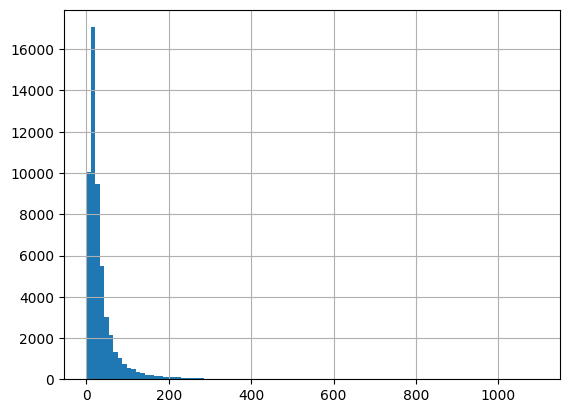

In [13]:
# Date time features
train_dev["DateTimeOfAccident"] = pd.to_datetime(train_dev["DateTimeOfAccident"])
train_dev["DateReported"] = pd.to_datetime(train_dev["DateReported"])
train_dev["ReportLag"] = (train_dev["DateReported"] - train_dev["DateTimeOfAccident"]).dt.days
print(train_dev["ReportLag"].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]))

train_dev.loc[:, 'ReportLag'] = train_dev['ReportLag'].clip(lower=0)
train_dev["ReportLag"].hist(bins=100)

In [14]:
columns_categorical = [
 'Gender',
 'MaritalStatus',
 'PartTimeFullTime',
]

columns_numerical = [
 'Age',
 'DependentChildren',
 'DependentsOther',
 'WeeklyWages',
 'HoursWorkedPerWeek',
 'DaysWorkedPerWeek',
 'InitialIncurredClaimsCost_log', # 'InitialIncurredClaimsCost',
 'ReportLag'
]
columns_text = ['ClaimDescription']
columns_target = ['UltimateIncurredClaimCost']

train_dev[columns_categorical] = train_dev[columns_categorical].astype("category")

categorical_columns = train_dev.select_dtypes(include="category").columns
n_categorical_features = len(categorical_columns)
n_numerical_features = train_dev.select_dtypes(include="number").shape[1]

print(f"Number of samples: {train_dev.shape[0]}")
print(f"Number of features: {train_dev.shape[1]}")
print(f"Number of categorical features: {n_categorical_features}")
print(f"Number of numerical features: {n_numerical_features}")

Number of samples: 54000
Number of features: 18
Number of categorical features: 3
Number of numerical features: 11


In [15]:
# Cap features that have long tail
train_dev['DependentChildren'] = train_dev['DependentChildren'].clip(upper=3)
train_dev['DependentsOther'] = train_dev['DependentsOther'].clip(upper=1)
train_dev['HoursWorkedPerWeek'] = train_dev['HoursWorkedPerWeek'].clip(upper=100)


count    54000.000000
mean         5.866460
std          0.655902
min          0.000000
10%          5.298317
20%          5.298317
30%          5.500074
40%          5.809577
50%          5.971772
60%          6.104177
70%          6.214608
80%          6.306301
90%          6.524224
95%          6.705646
99%          7.120865
100%         8.922258
max          8.922258
Name: WeeklyWages_log, dtype: float64
0    5.298317
Name: WeeklyWages_log, dtype: float64


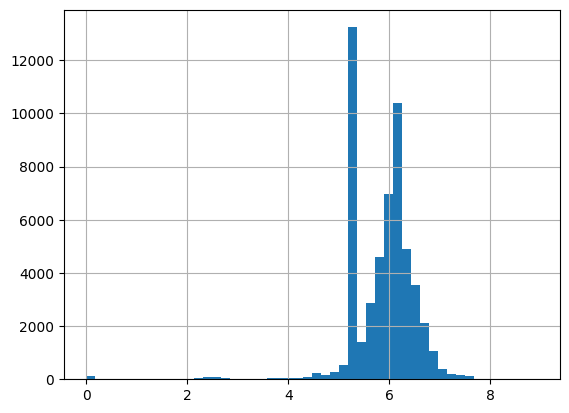

In [16]:
# Skew feature log transfer
train_dev['WeeklyWages_log'] = np.log(train_dev['WeeklyWages'])

print(train_dev['WeeklyWages_log'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]))
train_dev['WeeklyWages_log'].hist(bins=50)
print(train_dev['WeeklyWages_log'].mode())


In [17]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)

In [18]:
full_scaler = StandardScaler(with_std=False).fit(train_dev[columns_numerical])
# control_scaler = StandardScaler(with_std=False).fit(X_train)

# Modeling

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# from sklearn.feature_extraction import DictVectorizer
# vec = DictVectorizer(sparse=False, dtype=int)
# vec.fit_transform(train_dev)

In [21]:
# drop NA, infinity values
train_dev.replace(-np.inf, np.nan)
train_dev.replace(np.inf, np.nan)
train_dev.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredClaimsCost,UltimateIncurredClaimCost,InitialIncurredClaimsCost_log,UltimateIncurredClaimCost_log,ReportLag,WeeklyWages_log
0,WC8285054,2002-04-09 07:00:00+00:00,2002-07-05 00:00:00+00:00,48,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388,7.313220,8.465522,86,6.214608
1,WC6982224,1999-01-07 11:00:00+00:00,1999-01-20 00:00:00+00:00,43,F,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819,8.612503,8.752469,12,6.233116
2,WC5481426,1996-03-25 00:00:00+00:00,1996-04-14 00:00:00+00:00,30,M,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087,7.438384,7.738030,20,6.563997
3,WC9775968,2005-06-22 13:00:00+00:00,2005-07-22 00:00:00+00:00,41,M,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170,9.615805,9.786194,29,6.319797
4,WC2634037,1990-08-29 08:00:00+00:00,1990-09-27 00:00:00+00:00,36,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925,7.937375,8.297544,28,5.932510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53995,WC9370727,2004-08-21 18:00:00+00:00,2004-09-08 00:00:00+00:00,32,F,0,0,500.00,F,38.0,5,STRUCK KNIFE LACERATED LEFT MIDDLE FINGER LEFT...,1000,480.493308,6.907755,6.174813,17,6.214608
53996,WC8396269,2002-04-28 09:00:00+00:00,2002-09-03 00:00:00+00:00,20,F,0,0,500.00,F,40.0,5,LEFT HAND LACERATION LEFT SIDE BACK AND LEFT LEG,1000,755.735319,6.907755,6.627691,127,6.214608
53997,WC3609528,1992-02-28 09:00:00+00:00,1992-03-18 00:00:00+00:00,19,M,0,0,283.00,F,40.0,5,METAL SLIPPED ACROSS METAL CUT FINGER,210,418.178461,5.347108,6.035908,18,5.645447
53998,WC5038565,1995-01-10 07:00:00+00:00,1995-01-31 00:00:00+00:00,24,M,0,0,200.00,F,38.0,5,BURN WHILST USING SPANNER LACERATION RIGHT MID...,7500,2695.225700,8.922658,7.899237,20,5.298317


In [22]:
columns_X = columns_numerical # columns_categorical + columns_numerical, 
X = train_dev[columns_X]
# X = pd.get_dummies(data=train_dev[columns_categorical + columns_numerical], columns=columns_categorical, drop_first=True).values

y = train_dev['UltimateIncurredClaimCost_log']

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=12)

In [23]:
# import xgboost as xgb
# 
# # create a xgboost regression model
# model = xgb.XGBRegressor(enable_categorical=True, objective='reg:gamma', n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8, early_stopping_rounds=10)
# # Fit the model, test sets are used for early stopping.
# model.fit(X_train, y_train, eval_set=[(X_dev, y_dev)])
# # Save model into JSON format.
# # model.save_model("./model/xgboost.json")

In [24]:
import statsmodels.api as sm 

y_train_log = np.log(y_train)
y_dev_log = np.log(y_dev)

X_train_1 = sm.add_constant(X_train)
X_dev_1 = sm.add_constant(X_dev)
model = sm.OLS(y_train_log, X_train_1).fit()
print(model.summary())

# make a prediction
yhat_train_log = model.predict(X_train_1)
yhat_dev_log = model.predict(X_dev_1)

                                  OLS Regression Results                                 
Dep. Variable:     UltimateIncurredClaimCost_log   R-squared:                       0.742
Model:                                       OLS   Adj. R-squared:                  0.742
Method:                            Least Squares   F-statistic:                 1.555e+04
Date:                           Mon, 12 Aug 2024   Prob (F-statistic):               0.00
Time:                                   23:55:07   Log-Likelihood:                 39572.
No. Observations:                          43200   AIC:                        -7.913e+04
Df Residuals:                              43191   BIC:                        -7.905e+04
Df Model:                                      8                                         
Covariance Type:                       nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--

# Evaluation

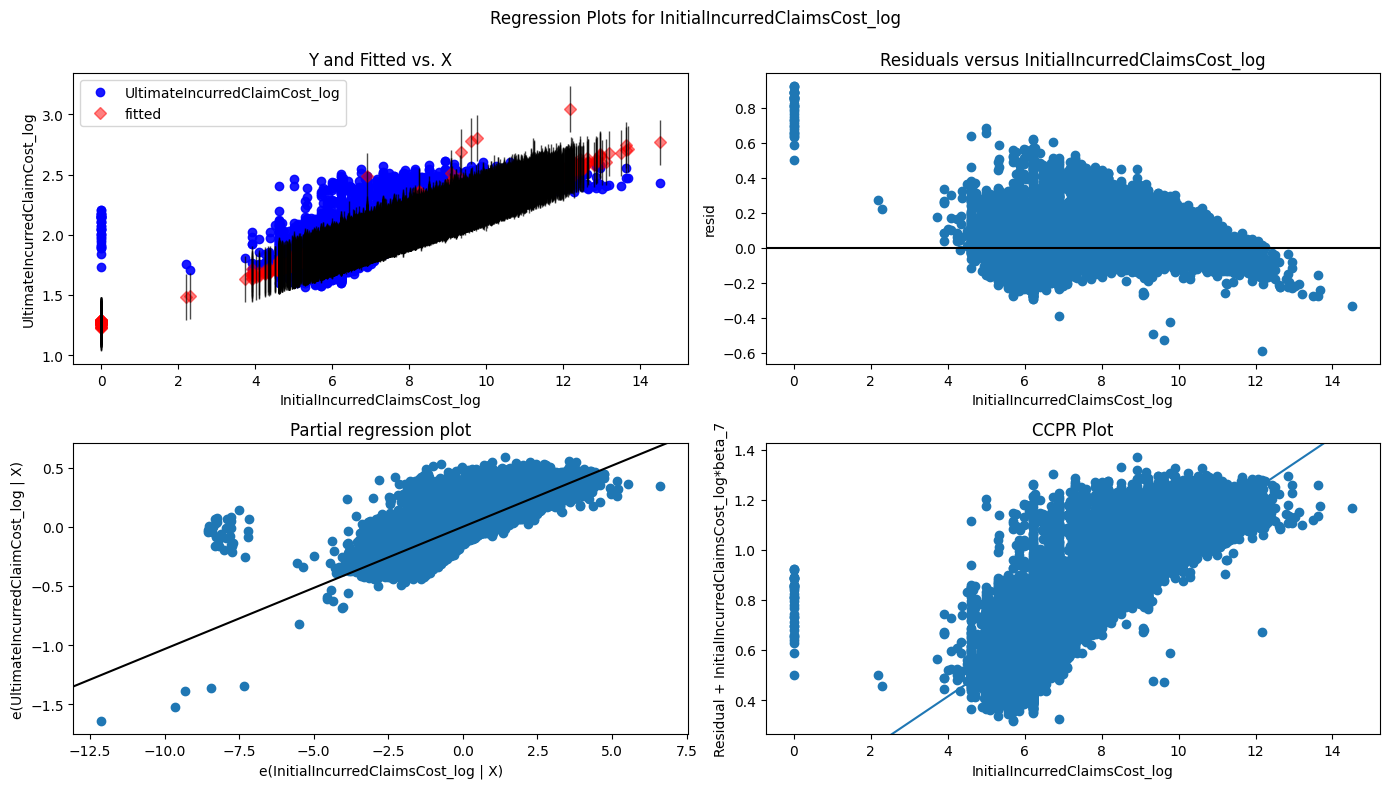

In [25]:
# creating regression plots 
fig = plt.figure(figsize=(14, 8)) 
fig = sm.graphics.plot_regress_exog(model, 'InitialIncurredClaimsCost_log', fig=fig) 

In [26]:
dev_eval = pd.DataFrame(X_dev.copy())
dev_eval["y"] = y_dev_log
dev_eval["yhat"] = yhat_dev_log
dev_eval.sort_values(by=['yhat'], ascending=True, inplace=True)

In [27]:
dev_eval.head()

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredClaimsCost_log,ReportLag,y,yhat
723,24,1,0,200.00,38.0,5,0.0,426,1.912982,1.235149
33307,17,0,0,334.96,38.0,5,0.0,5,2.128905,1.239675
39944,30,0,0,430.00,38.0,5,0.0,41,2.112939,1.256326
32582,40,0,0,500.00,40.0,5,0.0,820,2.069260,1.257462
15484,22,0,0,567.86,38.0,5,0.0,35,1.971215,1.260507


In [28]:
# Evaluate matrices
from sklearn import metrics 
r2_score = metrics.r2_score(y_dev_log, yhat_dev_log)
mean_squared_error = metrics.mean_squared_error(y_dev_log, yhat_dev_log)

print(f"Mean squared error: {mean_squared_error: 0.5f}")
print(f"R2 score: {r2_score: 0.5f}")

Mean squared error:  0.00978
R2 score:  0.73366


## R-Square
- [R Square wiki page](https://en.wikipedia.org/wiki/Coefficient_of_determination)
- [R² score documentation on sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score)
- https://stats.stackexchange.com/questions/324773/how-to-define-r-squared-on-a-subset-of-the-original-sample


R-Square = Var_explained / Var_Total = (Var_Total - Var_Residual) / Var_Total

Assumptions
- Linear regression. Relationship between dependent and independent variables are linear.
- When number of observation approaches infinity, the R Square should approach zero. 

Concerns with calculate R-Square on quantile data
- Which mean should it be use in the quantile?
    - Use the quantile mean and only the records in the quantile: This is same as r-square in the subset. But the regression is not fitted to this data, thus it is not informative for the regression model performance. For example, the subgroup with `InitialIncurredClaimsCost_log` value equal to zero, would have a much higher R square, since it is tightly group together. The total sum of squares used in subgroups is different from the total sum of squares of whole dataset. Thus, `total sum of squares = explained sum of squares + residual sum of squares` no longer hold.
    - Use the whole dataset mean and whole dataset as the denominator, but only include quantile data in numerator: The advantage of this approach is that sum of the R Square of each subgroup is the R Square of whole dataset. 

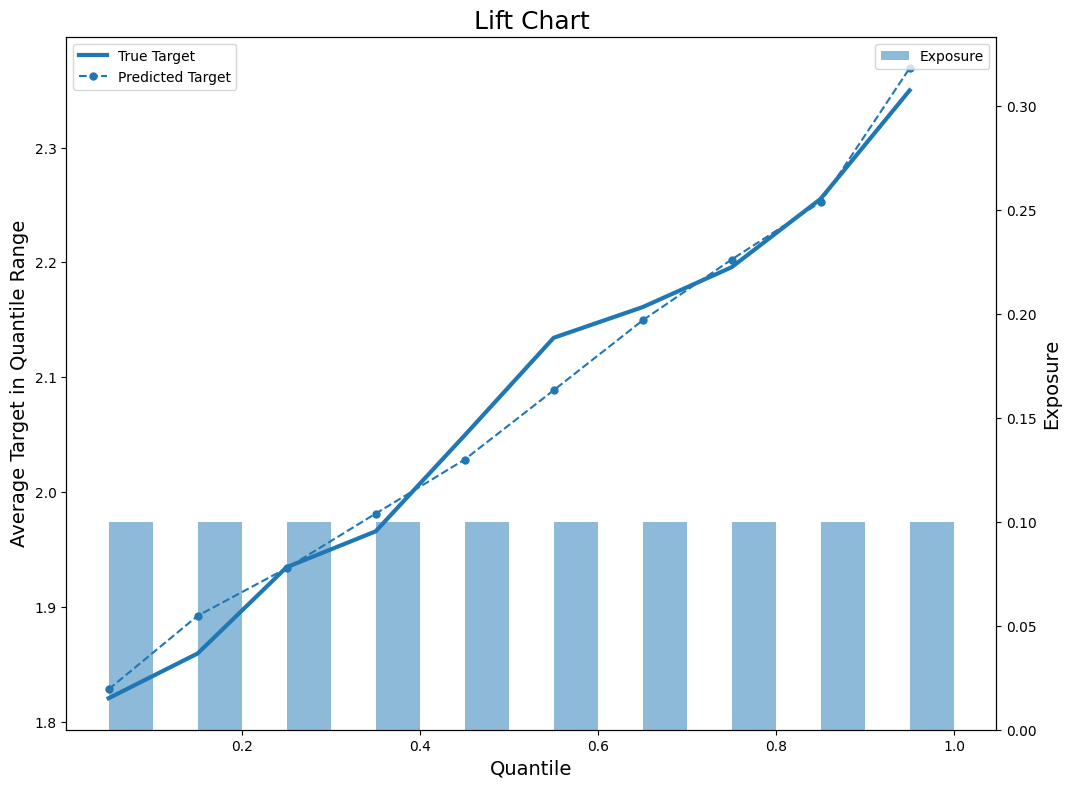

In [30]:
from utils import LiftChart


lift = LiftChart(y_dev_log, yhat_dev_log)
data_lift = lift.quantile_data_lift(n_quantiles=10)
ax = lift.quantile_plot(n_quantiles=10, chart="lift")

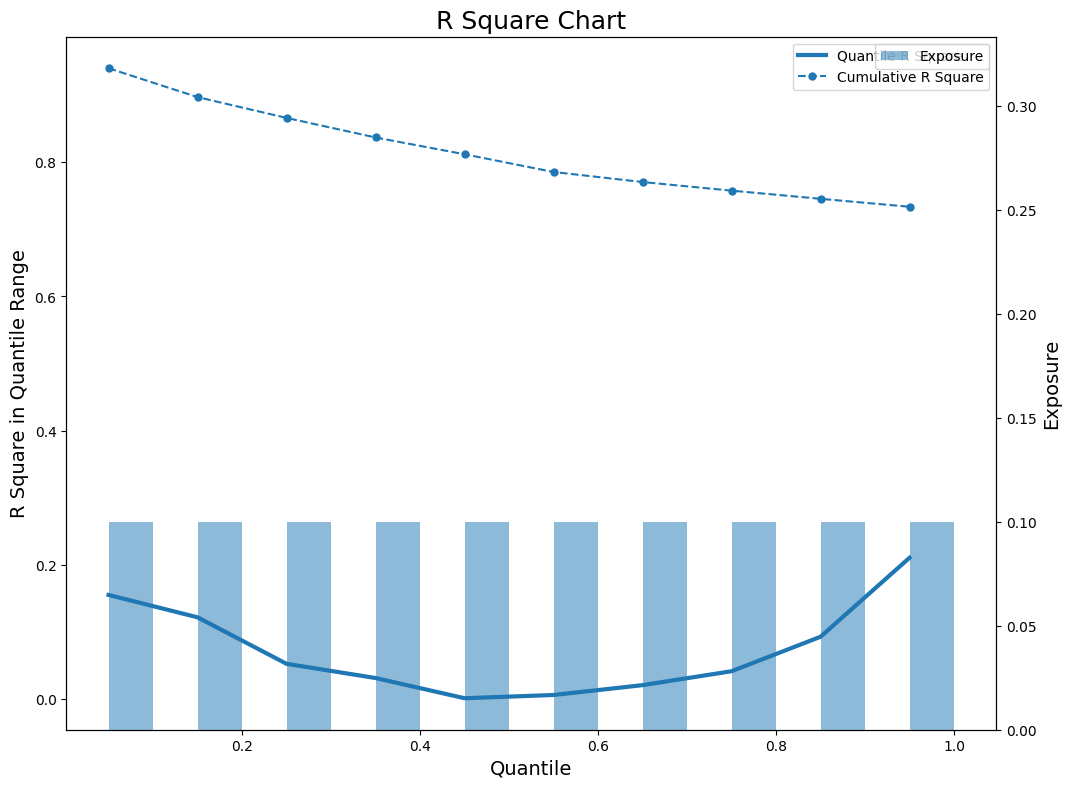

In [31]:
lift = LiftChart(y_dev_log, yhat_dev_log)
data_r_square = lift.quantile_data_r_square(n_quantiles=10)
ax = lift.quantile_plot(n_quantiles=10, chart="r_square")

In [36]:
columns = ["residual_total", "residual_explained"]
data_agg = lift.data.groupby("bin")[columns + ["exposure"]].sum().reset_index()
data_agg["exposure"] /= sum(data_agg["exposure"])

data_agg["r_square"] = (data_agg["ss_total"] - data_agg["ss_residual"]) / sum(data_agg["ss_total"])
data_agg["cumul_r_square"] = 1 - np.cumsum(data_agg["ss_residual"]) / sum(data_agg["ss_total"])

data_agg

KeyError: 'ss_total'

In [ ]:
from typing import Optional, List, Dict

class LiftChart:
    def __init__(self, y: np.array, yhat: np.array):
        """ Create the dataset for lift chart creation"""
        exposure = [1.0] * len(y)
        self.data = pd.DataFrame(
                {
                    "actual_y": y,
                    "predicted_y": yhat * (sum(y * exposure) / sum(yhat * exposure)), # rebase
                    "exposure": exposure,
                }
            )
        self.data.sort_values(by="predicted_y", inplace=True)
        self.data["cumul_exposure"] = np.cumsum(self.data["exposure"]) / np.sum(
                self.data["exposure"]
            )
    
    def quantile_data(self, n_quantiles: int = 10):
        """
        Divides data into n_quantiles, calculating the mean for each
        quantile. The data are split using the cumulated exposure, ensuring that
        each quantile has a balanced amount of exposure. This is described in
        Generalized Linear Models for Insurance Rating by Goldburd, Khare, Tevet.
        """
        quantile_dict = {
            "actual_y": [],
            "predicted_y": [],
        }
        srs_dict = self.data.to_dict('series')
        quantile_ee = []
        exposure = self.data["exposure"]
        exposure_frac = self.data["cumul_exposure"]
    
        # Create the quantiles using exposure_frac
        bin_width = 1 / float(n_quantiles)
        for i in range(1, n_quantiles + 1):
            lower_val = (i - 1) * bin_width
            upper_val = i * bin_width
            if i == n_quantiles:
                # last round, increase upper to make sure we see full data when using
                # left-closed right-open intervals.
                upper_val += 1
            quantile_index = exposure_frac[
                (exposure_frac >= lower_val) & (exposure_frac < upper_val)
            ].index
            tmp_ee = exposure.loc[quantile_index]
            quantile_ee.append(tmp_ee.sum())
            for key, lst in quantile_dict.items():
                tmp_srs = srs_dict[key].loc[quantile_index] * tmp_ee
                lst.append(tmp_srs.sum() / tmp_ee.sum())
        quantile_ee /= np.sum(quantile_ee)
        quantile_dict["exposure"] = list(quantile_ee)
        return quantile_dict
    
    def quantile_plot(self, n_quantiles=10,
        title: str = "Lift Chart",
        ax: plt.axis = None,
        file_name: Optional[str] = None,
    ) -> plt.Figure:
        """
        Plot or save the lift chart with selected number of buckets.
        """
        quantile_dict = self.quantile_data(n_quantiles)
        x = [(i + 0.5) / n_quantiles for i in range(n_quantiles)]
    
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 9))
    
        ax.plot(x, quantile_dict["actual_y"], ls="-", lw=3, label=f"True Target")
        clr = ax.lines[-1].get_color()
        ax.plot(
            x,
            quantile_dict["predicted_y"],
            ls="--",
            marker=".",
            markersize=10,
            color=clr,
            label=f"Predicted Target",
        )
        ax_dup = ax.twinx()
        ax_dup.bar(
            x,
            quantile_dict["exposure"],
            width=(0.5 / n_quantiles),
            align="edge",
            alpha=0.5,
            label="Exposure",
        )
        ax.set_xlabel("Quantile", size=14)
        ax.set_ylabel("Average Target in Quantile Range", size=14)
        ax_dup.set_ylabel("Exposure", size=14)
        ax_dup.set_ylim([0, 1 / (n_quantiles // 3)])
        ax.set_title(title, size=18)
        ax.legend()
        ax_dup.legend()
        if file_name:
            plt.savefig(file_name)
        return ax.figure


lift = LiftChart(y_dev_log, yhat_dev_log)
lift_data = lift.quantile_data(n_quantiles=10)
ax = lift.quantile_plot(n_quantiles=10)

In [ ]:
from typing import Optional, List, Dict, Union


def get_quantiles_with_exposure(
    data: pd.DataFrame,
    n_quantiles: int = 10,
) -> Dict[str, List[float]]:
    """
    Divides data into n_quantiles, calculating the mean for each
    quantile. The data are split using the cumulated exposure, ensuring that
    each quantile has a balanced amount of exposure. This is described in
    Generalized Linear Models for Insurance Rating by Goldburd, Khare, Tevet.
    """
    quantile_dict = {
        "actual_y": [],
        "predicted_y": [],
    }
    srs_dict = data.to_dict('series')
    quantile_ee = []
    exposure = data["exposure"]
    exposure_frac = data["cumul_exposure"]

    # Create the quantiles using exposure_frac
    bin_width = 1 / float(n_quantiles)
    for i in range(1, n_quantiles + 1):
        lower_val = (i - 1) * bin_width
        upper_val = i * bin_width
        if i == n_quantiles:
            # last round, increase upper to make sure we see full data when using
            # left-closed right-open intervals.
            upper_val += 1
        quantile_index = exposure_frac[
            (exposure_frac >= lower_val) & (exposure_frac < upper_val)
        ].index
        tmp_ee = exposure.loc[quantile_index]
        quantile_ee.append(tmp_ee.sum())
        for key, lst in quantile_dict.items():
            tmp_srs = srs_dict[key].loc[quantile_index] * tmp_ee
            lst.append(tmp_srs.sum() / tmp_ee.sum())
    quantile_ee /= np.sum(quantile_ee)
    quantile_dict["exposure"] = list(quantile_ee)
    return quantile_dict


def _get_quantile_data(yhat, y, 
    n_quantiles: int
) -> Dict[str, List[float]]:
    """
    Obtains a dictionary of quantiles for the quantile chart and values.
    """
    exposure = [1.0] * len(y)
    data = pd.DataFrame(
                {
                    "actual_y": y,
                    "predicted_y": yhat * (sum(y * exposure) / sum(yhat * exposure)), # rebase
                    "exposure": exposure,
                }
            )
    data.sort_values(by="predicted_y", inplace=True)
    data["cumul_exposure"] = np.cumsum(data["exposure"]) / np.sum(
                data["exposure"]
            )
    
    quantile_dict = get_quantiles_with_exposure(
        data=data,
        n_quantiles=n_quantiles,
    )
    return quantile_dict

def quantile_plot(yhat: np.array, y: np.array,
    n_quantiles=10,
    title: str = "Lift Chart",
    ax: plt.axis = None,
    file_name: Optional[str] = None,
) -> plt.Figure:
    quantile_dict = _get_quantile_data(yhat, y, n_quantiles)
    x = [(i + 0.5) / n_quantiles for i in range(n_quantiles)]

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 9))

    ax.plot(x, quantile_dict["actual_y"], ls="-", lw=3, label=f"True Target")
    clr = ax.lines[-1].get_color()
    ax.plot(
        x,
        quantile_dict["predicted_y"],
        ls="--",
        marker=".",
        markersize=10,
        color=clr,
        label=f"Predicted Target",
    )
    ax_dup = ax.twinx()
    ax_dup.bar(
        x,
        quantile_dict["exposure"],
        width=(0.5 / n_quantiles),
        align="edge",
        alpha=0.5,
        label="Exposure",
    )
    ax.set_xlabel("Quantile", size=14)
    ax.set_ylabel("Average Target in Quantile Range", size=14)
    ax_dup.set_ylabel("Exposure", size=14)
    ax_dup.set_ylim([0, 1 / (n_quantiles // 3)])
    ax.set_title(title, size=18)
    ax.legend()
    ax_dup.legend()
    if file_name:
        plt.savefig(file_name)
    return ax.figure

In [ ]:
# Lift Chart
quantile_plot(yhat_dev_log, y_dev_log, n_quantiles=10)